# Machine Learning Emulator of Snow-17, Part I: `XGBoost`

## 1. Prepare the Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

param_file = 'Snow17_NN_params.csv'
SWE_sim_file = 'Snow17_NN_SWE.csv'
forcing_file = 'Snow17_NN_forcing.csv'

date_beg_train = '2000-10-01' # This is the first day of water year 2000
date_end_train = '2015-09-30' # This is the last day of water year 2015

date_beg_test = '2015-10-01' # This is the first day of water year 2016
date_end_test = '2020-09-30' # This is the last day of water year 2020

Nens_train = 1000

## 2. Split Training and Testing Dataset

In [2]:
# Model parameters
df_params = pd.read_csv(param_file)

# Ensemble SWE simulation
df_swe_sim = pd.read_csv(SWE_sim_file)
df_swe_sim['Date'] = pd.to_datetime(df_swe_sim['Date'],format='%Y-%m-%d')
df_swe_sim.index = df_swe_sim['Date']

df_swe_sim_train = df_swe_sim[date_beg_train:date_end_train]
df_swe_sim_test = df_swe_sim[date_beg_test:date_end_test]

Nt_train = df_swe_sim_train.shape[0]
Nt_test = df_swe_sim_test.shape[0]

## Forcing
df_forcing = pd.read_csv(forcing_file)
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

df_forcing_train = df_forcing[date_beg_train:date_end_train]
df_forcing_test = df_forcing[date_beg_test:date_end_test]

Nreps = Nens_train

print('Nt_train = '+str(Nt_train))
print('Nt_test = '+str(Nt_test))
print('Nreps = '+str(Nreps))


Nt_train = 5478
Nt_test = 1827
Nreps = 1000


## 3. Assemble Training and Test Datasets Into Correct Format

In [3]:
# Process our "Obervations" we want the neural net to predict. In this case SWE
# Get the SWE ensemble and reshape it into a 1-D array, column-wise 

## TRAINING DATA
SWE_ens_train = df_swe_sim_train.iloc[:,2:(Nreps+2)].values
SWE_ens_1D_train = SWE_ens_train.T.reshape(Nt_train*Nreps,1)

print('Shape of SWE ensemble simulation - training: '+str(SWE_ens_1D_train.shape))

## TESTING DATA
SWE_ens_test = df_swe_sim_test.iloc[:,2:(Nreps+2)].values
SWE_ens_1D_test = SWE_ens_test.T.reshape(Nt_test*Nreps,1)

print('Shape of SWE ensemble simulation - test:'+str(SWE_ens_1D_test.shape))


Shape of SWE ensemble simulation - training: (5478000, 1)
Shape of SWE ensemble simulation - test:(1827000, 1)


In [4]:
# Process our forcings, making a copy for each ensemble member
## TRAINING DATA
tair_train = df_forcing_train['tair'].values.reshape((Nt_train,1))
tair_ens_train = np.tile(tair_train,(Nreps,1))
print('Shape of tair_ens_train = '+str(tair_ens_train.shape))

pcp_train = df_forcing_train['pcp'].values.reshape((Nt_train,1))
pcp_ens_train = np.tile(pcp_train,(Nreps,1))
print('Shape of pcp_ens_train = '+str(pcp_ens_train.shape))

## TESTING DATA
tair_test = df_forcing_test['tair'].values.reshape((Nt_test,1))
tair_ens_test = np.tile(tair_test,(Nreps,1))
print('Shape of tair_ens_test = '+str(tair_ens_test.shape))

pcp_test = df_forcing_test['pcp'].values.reshape((Nt_test,1))
pcp_ens_test = np.tile(pcp_test,(Nreps,1))
print('Shape of pcp_ens_test = '+str(pcp_ens_test.shape))


Shape of tair_ens_train = (5478000, 1)
Shape of pcp_ens_train = (5478000, 1)
Shape of tair_ens_test = (1827000, 1)
Shape of pcp_ens_test = (1827000, 1)


In [5]:
# Process our parameters making a copy for each date
## TRAINING DATA
Dd = df_params['Dd_ens'].iloc[0:Nreps].values.reshape((1,Nreps))
Dd_ens_train = np.tile(Dd,(Nt_train,1)).T.reshape((Nt_train*Nreps,1))

Tt = df_params['Tt_ens'].iloc[0:Nreps].values.reshape((1,Nreps))
Tt_ens_train = np.tile(Tt,(Nt_train,1)).T.reshape((Nt_train*Nreps,1))

print('Shape of Dd_ens_train = '+str(Dd_ens_train.shape))
print('Shape of Tt_ens_train = '+str(Tt_ens_train.shape))

## TESTING DATA
Dd_ens_test = np.tile(Dd,(Nt_test,1)).T.reshape((Nt_test*Nreps,1))
Tt_ens_test = np.tile(Tt,(Nt_test,1)).T.reshape((Nt_test*Nreps,1))

print('Shape of Dd_ens_test = '+str(Dd_ens_test.shape))
print('Shape of Tt_ens_test = '+str(Tt_ens_test.shape))


Shape of Dd_ens_train = (5478000, 1)
Shape of Tt_ens_train = (5478000, 1)
Shape of Dd_ens_test = (1827000, 1)
Shape of Tt_ens_test = (1827000, 1)


In [6]:
# Feature Engineering: Cyclical encoding of day of year

DOY_train = df_forcing_train.Date.dt.day_of_year.values

cos_DOY_train = np.tile(np.cos(DOY_train/366).reshape((Nt_train,1)),(Nreps,1))
sin_DOY_train = np.tile(np.sin(DOY_train/366).reshape((Nt_train,1)),(Nreps,1))

print('Shape of COS Day of Year - training: '+str(cos_DOY_train.shape))
print('Shape of SIN Day of Year - training: '+str(sin_DOY_train.shape))

DOY_test = df_forcing_test.Date.dt.day_of_year.values

cos_DOY_test = np.tile(np.cos(DOY_test/366).reshape((Nt_test,1)),(Nreps,1))
sin_DOY_test = np.tile(np.sin(DOY_test/366).reshape((Nt_test,1)),(Nreps,1))

print('Shape of COS Day of Year - test: '+str(cos_DOY_test.shape))
print('Shape of SIN Day of Year - test: '+str(sin_DOY_test.shape))


Shape of COS Day of Year - training: (5478000, 1)
Shape of SIN Day of Year - training: (5478000, 1)
Shape of COS Day of Year - test: (1827000, 1)
Shape of SIN Day of Year - test: (1827000, 1)


In [7]:
# Include actual forcings and engineered features:
# Assemble predictor array - training data
SWE_predictors_train = np.concatenate((cos_DOY_train,sin_DOY_train,pcp_ens_train,tair_ens_train,Dd_ens_train,Tt_ens_train),axis=1)
print('SWE_predictors_train dimensions = '+str(SWE_predictors_train.shape))

# Assemble predictor array - test data
SWE_predictors_test = np.concatenate((cos_DOY_test,sin_DOY_test,pcp_ens_test,tair_ens_test,Dd_ens_test,Tt_ens_test),axis=1)
print('SWE_predictors_test dimensions = '+str(SWE_predictors_test.shape))

# Include only actual forcings:
# # Assemble predictor array - training data
# SWE_predictors_train = np.concatenate((pcp_ens_train,tair_ens_train,Dd_ens_train,Tt_ens_train),axis=1)
# print('SWE_predictors_train dimensions = '+str(SWE_predictors_train.shape))

# # Assemble predictor array - test data
# SWE_predictors_test = np.concatenate((pcp_ens_test,tair_ens_test,Dd_ens_test,Tt_ens_test),axis=1)
# print('SWE_predictors_test dimensions = '+str(SWE_predictors_test.shape))


SWE_predictors_train dimensions = (5478000, 6)
SWE_predictors_test dimensions = (1827000, 6)


## 4. Train the `XGBoost` Model

In [8]:
%%time 

# Initialize scalers
scaler_predictors = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the training and testing predictor data
SWE_predictors_train_scaled = scaler_predictors.fit_transform(SWE_predictors_train)
SWE_predictors_test_scaled = scaler_predictors.transform(SWE_predictors_test)

# Scale the target variable (SWE)
SWE_ens_1D_train_scaled = scaler_target.fit_transform(SWE_ens_1D_train)
SWE_ens_1D_test_scaled = scaler_target.transform(SWE_ens_1D_train)

xg_reg = xgb.XGBRegressor(n_estimators=500,
                          learning_rate=0.01,
                          random_state=42,
                          max_depth=5,
                          objective='reg:squaredlogerror'
                          )
xg_reg.fit(SWE_predictors_train_scaled, SWE_ens_1D_train_scaled)


CPU times: user 2min 44s, sys: 35.9 s, total: 3min 20s
Wall time: 49.8 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [9]:
# Make predictions of out-of-sample times 
swe_ens_1D_predict_test_scaled = xg_reg.predict(SWE_predictors_test_scaled)

# Inverse transform the predictions to original scale
swe_ens_1D_predict_test = scaler_target.inverse_transform(swe_ens_1D_predict_test_scaled.reshape(-1, 1))

print(swe_ens_1D_predict_test.shape)

# Reshape the predictions to get the time series for each predicted replicate
swe_ens_predict_test = swe_ens_1D_predict_test.reshape((Nreps,Nt_test)).T
print(swe_ens_predict_test.shape)

(1827000, 1)
(1827, 1000)


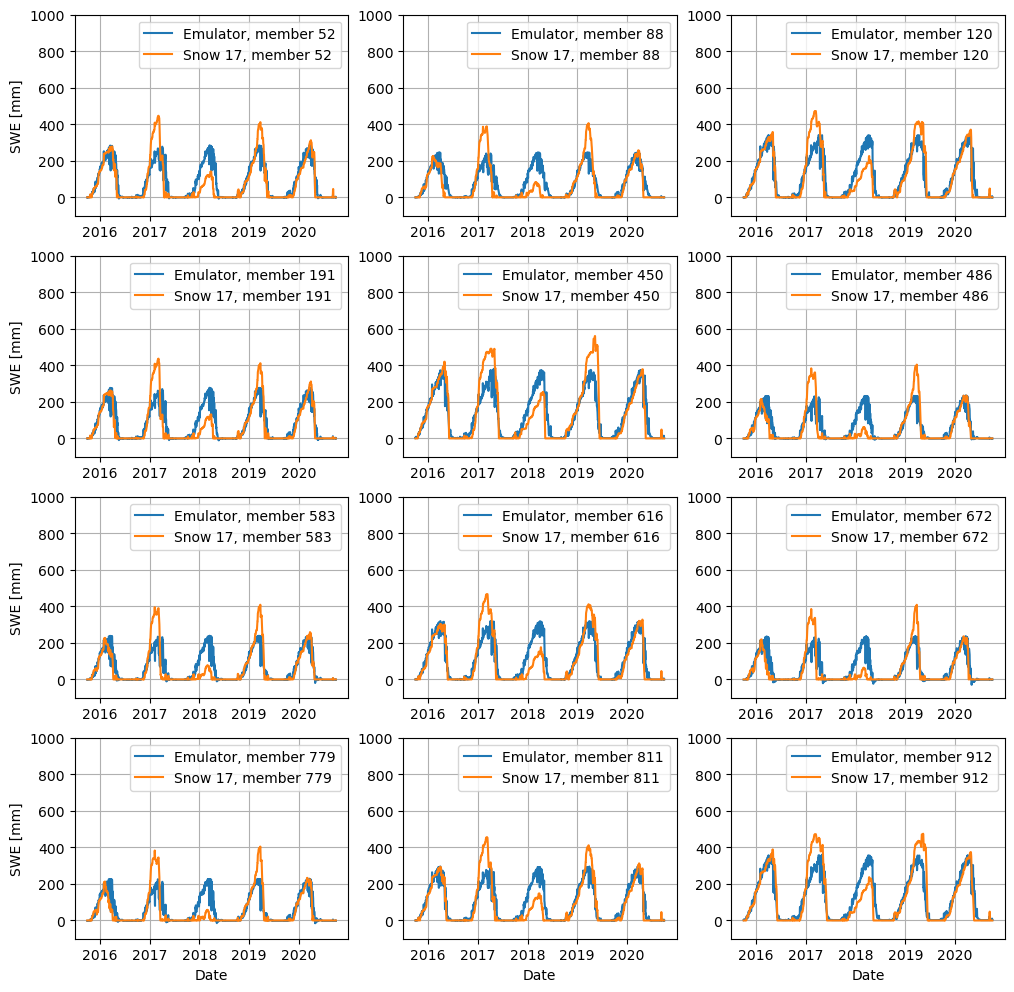

In [10]:
n_plots = 12

# Create a random sample of 12 ensemble members to plot, sorted from lowest to highest ensemble member number
ens = np.sort(np.random.permutation(Nreps)[0:n_plots])

plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 10})
for i in np.arange(n_plots):
    plt.subplot(4,3,i+1)
    plt.plot(df_forcing_test['Date'],swe_ens_predict_test[:,ens[i]],label='Emulator, member '+str(ens[i]))
    plt.plot(df_forcing_test['Date'],SWE_ens_test[:,ens[i]],label='Snow 17, member '+str(ens[i]))
    if (i+1) > 9 and (i+1) <= 12:
        plt.xlabel('Date')
    if (i+1) == 1 or (i+1) == 4 or (i+1) == 7 or (i+1) == 10:
        plt.ylabel('SWE [mm]')
    plt.ylim([-100,1000])
    plt.grid('on')
    plt.legend()
plt.show()